In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

from pathlib import Path

import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import torch
import cv2

## Подготовка данных

In [2]:
## загрузите датасет https://drive.google.com/open?id=0BxYys69jI14kYVM3aVhKS1VhRUk 
pdata = Path('../../UTKFace/')

In [3]:
fns = list(pdata.glob('*.jpg'))
fns = [fn for fn in fns if len(str(fn).split('/')[-1].split('_'))==4 and '__' not in str(fn)]
print(len(fns))
fns[:3]

23705


[PosixPath('../../UTKFace/33_0_0_20170105165028532.jpg.chip.jpg'),
 PosixPath('../../UTKFace/90_1_0_20170110182536477.jpg.chip.jpg'),
 PosixPath('../../UTKFace/32_1_1_20170113012946729.jpg.chip.jpg')]

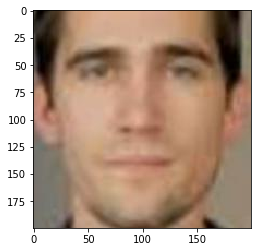

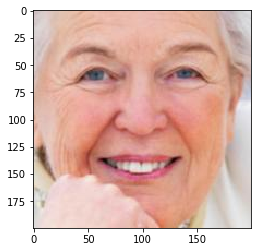

In [4]:
def show_img(fn):
    plt.figure()
    img = cv2.imread(str(fn))[:,:,::-1]
    plt.imshow(img)
for _ in range(2): show_img(np.random.choice(fns))

In [5]:
i2fn = fns
fn2i = {fn:i for i,fn in enumerate(i2fn)}
bs_fns = [fn.parts[-1] for fn in fns]
bs_fns[:3]

['33_0_0_20170105165028532.jpg.chip.jpg',
 '90_1_0_20170110182536477.jpg.chip.jpg',
 '32_1_1_20170113012946729.jpg.chip.jpg']

In [6]:
i2age, i2gender, i2race = zip(*[bs_fn.split('_')[:3] for bs_fn in bs_fns])
i2age = np.array(i2age, dtype=np.float32)
i2gender = np.array(i2gender, dtype=np.int64)
i2race = np.array(i2race, dtype=np.int64)

o2gender = {0: 'male', 1: 'female'}
o2race = dict(list(enumerate(('White', 'Black', 'Asian', 'Indian', 'Others'))))

i2race_verbose = [o2race[int(o)] for o in i2race]
i2gender_verbose = [o2gender[int(o)] for o in i2gender]
print(Counter(i2gender_verbose))

Counter({'male': 12391, 'female': 11314})


In [7]:
Counter(i2race_verbose).most_common()

[('White', 10078),
 ('Black', 4526),
 ('Indian', 3975),
 ('Asian', 3434),
 ('Others', 1692)]

In [8]:
sorted(Counter(list(zip(i2race_verbose, i2gender_verbose))).items(),key=lambda x: x[1], reverse=True)

[(('White', 'male'), 5477),
 (('White', 'female'), 4601),
 (('Black', 'male'), 2318),
 (('Indian', 'male'), 2261),
 (('Black', 'female'), 2208),
 (('Asian', 'female'), 1859),
 (('Indian', 'female'), 1714),
 (('Asian', 'male'), 1575),
 (('Others', 'female'), 932),
 (('Others', 'male'), 760)]

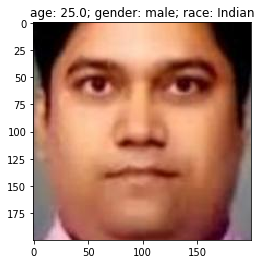

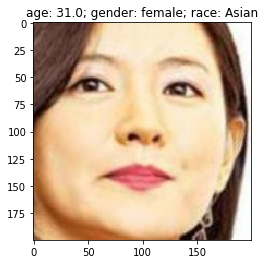

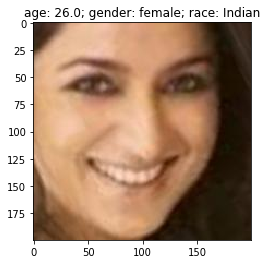

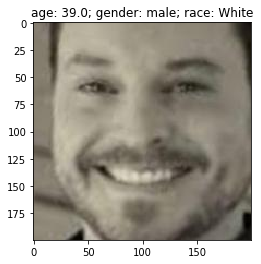

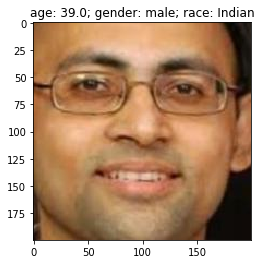

In [9]:
def show_random_img():
    fn = np.random.choice(fns)
    i = fn2i[fn]
    show_img(fn)
    plt.title(f'age: {i2age[i]}; gender: {i2gender_verbose[i]}; race: {i2race_verbose[i]}')
    
for _ in range(5): show_random_img()

In [10]:
df = pd.DataFrame({'img_name': bs_fns, 'age': i2age, 'gender': i2gender, 'race': i2race})
df['is_train'] = np.random.choice(2, size=len(df), p=[0.2, 0.8])
df.head()

,age,gender,img_name,race,is_train
0,33.0,0,33_0_0_20170105165028532.jpg.chip.jpg,0,1
1,90.0,1,90_1_0_20170110182536477.jpg.chip.jpg,0,0
2,32.0,1,32_1_1_20170113012946729.jpg.chip.jpg,1,1
3,19.0,0,19_0_2_20170102234958195.jpg.chip.jpg,2,1
4,41.0,0,41_0_0_20170117131132677.jpg.chip.jpg,0,0


# Обучение моделей

## Классификация пола

In [11]:
from dataloaders import ImagesDataset
from torch.utils.data import DataLoader
from torchvision.transforms import Compose, ToTensor, Normalize
import torch.nn as nn
from model import ResnetModel
from collections import namedtuple
from train_utils import train, validate
from tqdm import tqdm_notebook as tqdm
from train_utils import AccuracyMetric, AccuracyPart
import torch 
import pandas as pd
from pathlib import PosixPath

In [94]:
# предобученные модели и ембединги вы можете скачать отсюда: 
# https://drive.google.com/open?id=1LcaIDe0AIWe_MzS2BBHxtGKUy0F8J73P

In [84]:
args = namedtuple('args', [])
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
args.device = device
args.print_freq = 1
args.batch_size = 128

In [85]:
df = pd.read_csv('img2targets.csv')
df["img_name"] = df["img_name"].apply(lambda x: pdata / x)
df.head()

,img_name,age,gender,race,is_train
0,../../UTKFace/100_0_0_20170112213500903.jpg.ch...,100.0,0,0,0
1,../../UTKFace/100_0_0_20170112215240346.jpg.ch...,100.0,0,0,1
2,../../UTKFace/100_1_0_20170110183726390.jpg.ch...,100.0,1,0,1
3,../../UTKFace/100_1_0_20170112213001988.jpg.ch...,100.0,1,0,1
4,../../UTKFace/100_1_0_20170112213303693.jpg.ch...,100.0,1,0,1


### Определение даталоадеров

Нам необходимо два загрузчика данных -- для тренировки и для тестирования. 

dataset[i] должен возвращать преобразованную в тензор картинку и соответствующие лейблы (их может быть несколько)


In [86]:
def get_data(classes, transforms):
    datasets = {x: ImagesDataset(df=df, image_paths_name="img_name", labels_names=classes, 
                             is_train=x == "train", transform=transforms) for x in ["train", "dev"]}

    dataloaders = {x: DataLoader(dataset=datasets[x], batch_size=args.batch_size, 
                                 shuffle=True, num_workers=0, pin_memory=False, 
                                 drop_last=True) 
                  for x in ["train", "dev"]}
    return datasets, dataloaders

In [87]:
transforms = Compose([ToTensor(),
                      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])

datasets, dataloaders = get_data(classes=["gender"], transforms=transforms)

### Модель, лосс, оптимизатор

Для классификации мы будем использовать предобученный Resnet18. После feature extraction добавим два полносвязных слоя с дропаутом и релу.

In [88]:
model = ResnetModel(2, dp=0.5).to(device)
model.head

Sequential(
  (0): AdaptiveMaxPool2d(output_size=1)
  (1): Flatten()
  (2): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (3): Dropout(p=0.25)
  (4): Linear(in_features=512, out_features=512, bias=True)
  (5): ReLU(inplace)
  (6): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (7): Dropout(p=0.5)
  (8): Linear(in_features=512, out_features=2, bias=True)
)

In [79]:
# в качестве лосса -- стандартная кросс энтропия

criterion = nn.modules.loss.CrossEntropyLoss()
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)

# = через три эпохи уменьшить learning rate в 10 раз
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.1)

# метрика за которой хотим "следить" во время обучения
metrics = [AccuracyMetric()]

In [80]:
def train_model(model, dataloaders, criterion, optimizer, scheduler, metrics, epochs=5):
    for epoch in tqdm(range(epochs)):
        scheduler.step()
        train(dataloaders["train"], model, criterion, optimizer, epoch, args, metrics=metrics)
        validate(dataloaders["dev"], model, criterion, args, metrics=metrics)

In [90]:
## если у вас cpu, то рекомендуетс пропустить блок с обучением и загрузить обученную модель
# model.load_state_dict(torch.load("gender_model.pth", map_location=device))
# validate(dataloaders["dev"], model, criterion, args, metrics=metrics)

In [83]:
# обучение лучше производить на gpu. для инференса на cpu воспользуйтесь загрузкой модели 
train_model(model, dataloaders, criterion, optimizer, scheduler, metrics, epochs=5)

Epoch: [0][0/147]	Loss 0.7548 (0.7548)	Acc 50.0000 (50.0000)	
Epoch: [0][50/147]	Loss 0.4983 (0.3560)	Acc 78.1250 (83.8848)	
Epoch: [0][100/147]	Loss 0.1579 (0.3044)	Acc 92.1875 (86.2005)	
Test: [0/37]	Loss 0.2338 (0.2338) 	Acc 90.6250 (90.6250)	
 * Loss 0.226	Acc 90.7095	
Epoch: [1][0/147]	Loss 0.1777 (0.1777)	Acc 92.1875 (92.1875)	
Epoch: [1][50/147]	Loss 0.1784 (0.2000)	Acc 93.7500 (91.7586)	
Epoch: [1][100/147]	Loss 0.2383 (0.1923)	Acc 92.1875 (92.2416)	
Test: [0/37]	Loss 0.2834 (0.2834) 	Acc 89.0625 (89.0625)	
 * Loss 0.211	Acc 91.3640	
Epoch: [2][0/147]	Loss 0.1558 (0.1558)	Acc 94.5312 (94.5312)	
Epoch: [2][50/147]	Loss 0.1788 (0.1643)	Acc 95.3125 (93.7960)	
Epoch: [2][100/147]	Loss 0.2499 (0.1650)	Acc 88.2812 (93.6417)	
Test: [0/37]	Loss 0.2427 (0.2427) 	Acc 90.6250 (90.6250)	
 * Loss 0.187	Acc 92.1030	
Epoch: [3][0/147]	Loss 0.1481 (0.1481)	Acc 96.0938 (96.0938)	
Epoch: [3][50/147]	Loss 0.1023 (0.1152)	Acc 97.6562 (95.7261)	
Epoch: [3][100/147]	Loss 0.0965 (0.1030)	Acc 96.0938 

In [84]:
torch.save(model.state_dict(), "gender_model.pth")

## Классификация расы

In [95]:
datasets, dataloaders = get_data(classes=["race"], transforms=transforms)

In [131]:
# меняем только количество классов
model = ResnetModel(5, dp=0.5).to(device)
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.1)

In [91]:
## если у вас cpu, то рекомендуется пропустить блок с обучением и загрузить обученную модель
# model.load_state_dict(torch.load("race_model.pth", map_location=device))
# validate(dataloaders["dev"], model, criterion, args, metrics=metrics)

In [91]:
train_model(model, dataloaders, criterion, optimizer, scheduler, metrics, epochs=5)

Epoch: [0][0/147]	Loss 1.7206 (1.7206)	Acc 17.9688 (17.9688)	
Epoch: [0][50/147]	Loss 0.7410 (0.9218)	Acc 74.2188 (67.4786)	
Epoch: [0][100/147]	Loss 0.6672 (0.7932)	Acc 78.1250 (72.6408)	
Test: [0/37]	Loss 0.6611 (0.6611) 	Acc 72.6562 (72.6562)	
 * Loss 0.699	Acc 76.2247	
Epoch: [1][0/147]	Loss 0.4705 (0.4705)	Acc 86.7188 (86.7188)	
Epoch: [1][50/147]	Loss 0.4795 (0.5335)	Acc 83.5938 (81.8781)	
Epoch: [1][100/147]	Loss 0.5264 (0.5249)	Acc 82.8125 (82.2633)	
Test: [0/37]	Loss 0.3272 (0.3272) 	Acc 92.1875 (92.1875)	
 * Loss 0.540	Acc 81.7145	
Epoch: [2][0/147]	Loss 0.4573 (0.4573)	Acc 85.1562 (85.1562)	
Epoch: [2][50/147]	Loss 0.3894 (0.4116)	Acc 85.1562 (86.1673)	
Epoch: [2][100/147]	Loss 0.5736 (0.4306)	Acc 78.9062 (85.4657)	
Test: [0/37]	Loss 0.5647 (0.5647) 	Acc 79.6875 (79.6875)	
 * Loss 0.639	Acc 79.0329	
Epoch: [3][0/147]	Loss 0.3413 (0.3413)	Acc 89.0625 (89.0625)	
Epoch: [3][50/147]	Loss 0.2197 (0.3019)	Acc 91.4062 (89.9969)	
Epoch: [3][100/147]	Loss 0.2695 (0.2843)	Acc 89.8438 

In [92]:
torch.save(model.state_dict(), "race_model.pth")

## Multi-task 

In [42]:
datasets, dataloaders = get_data(classes=["race", "gender"], transforms=transforms)

In [134]:
# финальный лосс -- сумма лоссов по каждой из задач
def multi_task_loss(input, targets):
    race_loss = nn.functional.cross_entropy(input[:, :5], targets[:, 0])
    gender_loss = nn.functional.cross_entropy(input[:, 5:], targets[:, 1])
    return race_loss + gender_loss

metrics = [AccuracyPart(name="RaceAcc", output_slice=slice(0, 5), target_column=0),
           AccuracyPart(name="GenderAcc", output_slice=slice(5, 7), target_column=1)]

In [135]:
# меняем количество классов и лосс
model = ResnetModel(7, dp=0.5).to(device)
criterion = multi_task_loss
optimizer = torch.optim.Adam(filter(lambda p: p.requires_grad, model.parameters()), lr=1e-3)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer=optimizer, step_size=3, gamma=0.1)

In [92]:
## если у вас cpu, то рекомендуется пропустить блок с обучением и загрузить обученную модель
# model.load_state_dict(torch.load("race_and_gender_model.pth", map_location=device))
# validate(dataloaders["dev"], model, criterion, args, metrics=metrics)

In [99]:
train_model(model, dataloaders, criterion, optimizer, scheduler, metrics, epochs=5)

Epoch: [0][0/147]	Loss 2.4350 (2.4350)	RaceAcc 21.0938 (21.0938)	GenderAcc 51.5625 (51.5625)	
Epoch: [0][50/147]	Loss 1.1757 (1.3190)	RaceAcc 72.6562 (66.0846)	GenderAcc 78.9062 (82.4295)	
Epoch: [0][100/147]	Loss 0.8745 (1.1291)	RaceAcc 78.1250 (71.6662)	GenderAcc 91.4062 (85.4425)	
Test: [0/37]	Loss 0.8662 (0.8662) 	RaceAcc 80.4688 (80.4688)	GenderAcc 88.2812 (88.2812)	
 * Loss 0.899	RaceAcc 79.4130	GenderAcc 89.4426	
Epoch: [1][0/147]	Loss 0.8138 (0.8138)	RaceAcc 78.9062 (78.9062)	GenderAcc 85.9375 (85.9375)	
Epoch: [1][50/147]	Loss 0.7355 (0.7103)	RaceAcc 82.8125 (82.7053)	GenderAcc 92.9688 (92.0496)	
Epoch: [1][100/147]	Loss 0.7973 (0.7283)	RaceAcc 82.8125 (82.5650)	GenderAcc 87.5000 (91.5919)	
Test: [0/37]	Loss 0.9053 (0.9053) 	RaceAcc 76.5625 (76.5625)	GenderAcc 91.4062 (91.4062)	
 * Loss 0.855	RaceAcc 77.3015	GenderAcc 90.8573	
Epoch: [2][0/147]	Loss 0.6735 (0.6735)	RaceAcc 78.9062 (78.9062)	GenderAcc 92.9688 (92.9688)	
Epoch: [2][50/147]	Loss 0.4686 (0.5670)	RaceAcc 85.1562 (8

In [100]:
torch.save(model.state_dict(), "race_and_gender_model.pth")

In [43]:
def try_multi_on_img(dataset, idx):
    tensor, label = dataset[idx]
    with torch.no_grad():
        model.eval()
        prediction = model(tensor.unsqueeze(0)).detach().cpu().numpy()[0]
        race = np.argmax(prediction[:5])
        gender = np.argmax(prediction[5:])
        show_img(dataset.image_paths[idx])
        plt.title(f"Real: race - {o2race[label[0]]},  gender - {o2gender[label[1]]}. \n \
        Predicted: race - {o2race[race]}, gender - {o2gender[gender]}")

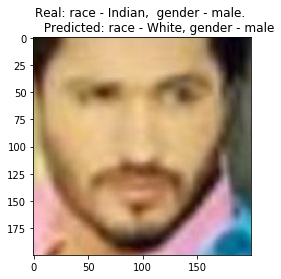

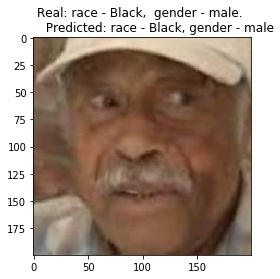

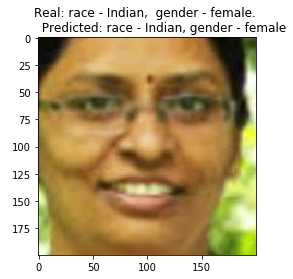

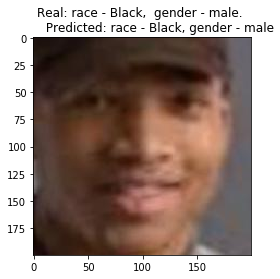

In [44]:
model = ResnetModel(7, dp=0.5).to(device)
state_dict = torch.load("race_and_gender_model.pth", map_location="cpu")
model.load_state_dict(state_dict)


for _ in range(4): try_multi_on_img(datasets["dev"], np.random.randint(len(datasets["dev"])))

# Сравнение ембеддингов

Посмотрим, как выглядят признаки перед последним слоем для разных моделей. Размерность таких признаков -- 512.

Для этого воспользуемся функцией get_embedding() нашего классификатора. 

In [103]:
def compute_embeddings(model, dataloader):
    all_embeddings = []
    all_labels = []
    with torch.no_grad():
        model.eval()
        for i, (data, labels) in tqdm(enumerate(dataloader)):
            all_labels.append(labels.numpy())
            data = data.to(device)
            embeddings = model.get_embedding(data).detach().cpu().numpy()
            all_embeddings.append(embeddings)
        
    return all_embeddings, all_labels
def save_for_projector(embeddings, metadata, name):
    embeddings = pd.DataFrame(np.concatenate(embeddings))
    metadata = pd.DataFrame(np.concatenate(metadata), columns=["Race", "Gender"])
    embeddings.to_csv(f"embeddings_{name}.tsv", header=None, index=None, sep="\t")
    metadata.to_csv(f"metadata_{name}.tsv", index=None, sep="\t")


In [105]:
model = ResnetModel(7, dp=0.5).to(device)
state_dict = torch.load("race_and_gender_model.pth", map_location=device)
model.load_state_dict(state_dict)

embeddings, metadata = compute_embeddings(model, dataloaders["dev"])
save_for_projector(embeddings, metadata, "race&gender")

model = ResnetModel(2, dp=0.5).to(device)
state_dict = torch.load("gender_model.pth", map_location=device)
model.load_state_dict(state_dict)

embeddings, metadata = compute_embeddings(model, dataloaders["dev"])
save_for_projector(embeddings, metadata, "gender_only")

### Загрузив полученные файлы в https://projector.tensorflow.org/ получаем ...

Для гендерной модели, отчетливо выделяется кластера -- male, female

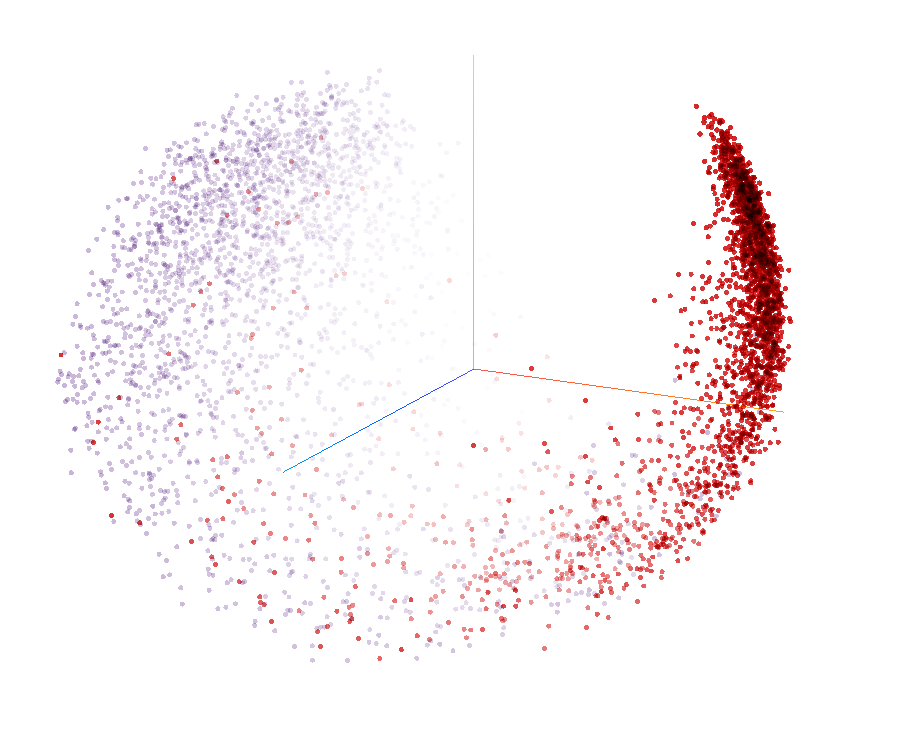

In [159]:
from IPython.display import Image
from IPython.core.display import HTML 
W = 400
Image(filename="images/gender_only_gender.PNG", width=W)

При этом расы расположены "в перемешку"

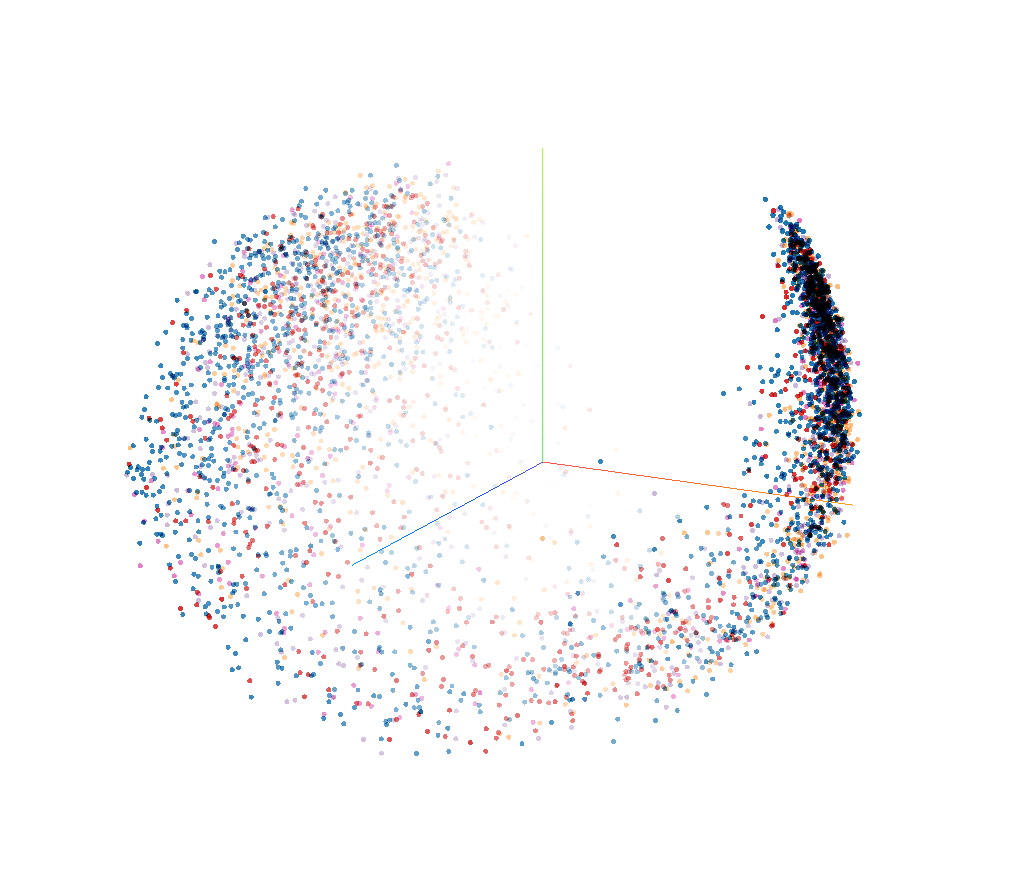

In [160]:
Image(filename="images/gender_only_race.PNG", width=W)

Модель, отвечающая сразу за две задачи выучила соответствующие признаки, в пространстве которых объекты близки как по полу так и по расе

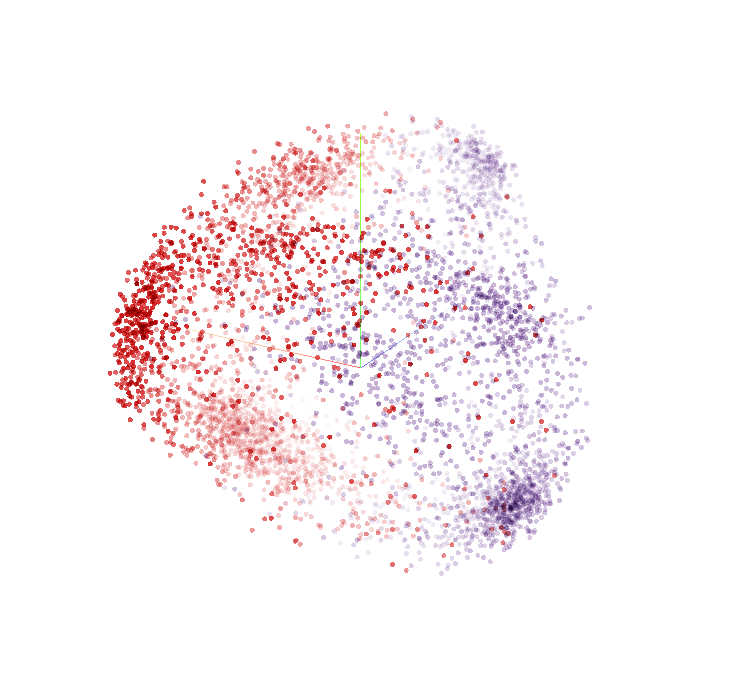

In [161]:
Image(filename="images/gender&race_gender.PNG", width=W)

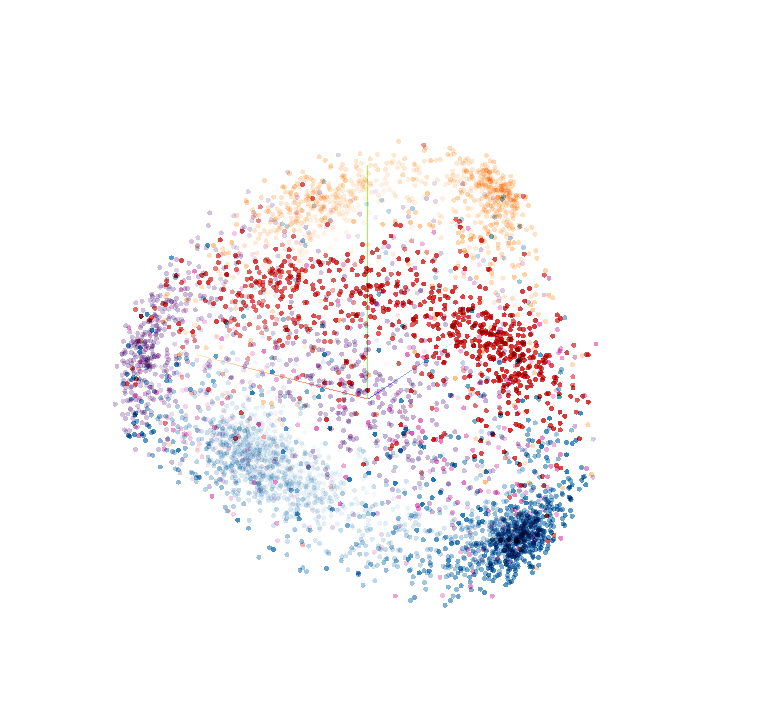

In [162]:
Image(filename="images/gender&race_race.PNG", width=W)